# Progetto basato su conoscenza
Progetto basato su conoscenza per l'esame di Ingegneria Della Conoscenza

## 1) Introduzione

Risultati su studi che intercettano fattori di abbandono dei giochi online multigiocatore, mostrano che le motivazioni più rilevanti sono dovute da: https://www.sciencedirect.com/science/article/abs/pii/S1875952117300770

- problemi di attesa, latenza/prestazioni(più rilevanti)
- l'equità del gioco(divario tra giocatori).

### 1.1) Scenario
Si simula lo scenario in cui verrà avviato un nuovo servizio online per il lancio di un nuovo gioco multiplayer. Dato dal picco di giocatori nei primi giorni di uscita del servizio, si prevede si dovrà gestire un carico molto elevato di richieste di partecipazione da parte degli utenti. Si assume che:

- Le risorse server potrebbero risultare limitate rispetto alla popolazione di giocatori 
- Periodicamente viene fornito al sistema un numero limitato di partite istanziabili rispetto alle risorse disponibili
- Ci siano un certa popolazione di giocatori in fase di ricerca di una nuova partita
- In base a dei lavori di ricerca è stato constatato che giocatori tendono ad abbandonare la ricerca di una partita se: i giocatori attendono in coda da troppo tempo, le partite sono composte da giocatori troppo differenti rendendo il gioco squilibrato e frustrante 

### 1.2) Obiettivo
L'obiettivo di questo problema è ottimizzare al meglio l'utilizzo delle risorse(limitate), massimizzando l'efficienza dei server online per gestire al meglio il picco di giocatori atteso al lancio. Riducendo quindi il rischio di abbandono da parte dei giocatori, dovuto a lunghe attese o a partite squilibrate. Si vuole quindi sviluppare un sistema di modelli basati su conoscenza che sfrutti conoscenza pregressa già disponibile sui giocatori iscritti alla piattaforma, rispetto ai giochi precedentemente giocati.

Per favorire i criteri legati ai partecipanti. Sarà quindi fondamentale estrarre conoscenza da quella pregressa, per:
- comporre partite di giocatori chegiocando in modo simile rilevando le possibili classi naturali di giocatori(clustering)
- classificare periodicamente i nuovi giocatori rispetto alle loro statistiche affinchè vengano assegnati ad una certa classe

Un algoritmo di ricerca locale(Local Search for Optimization) costruirà l'assegnazione ottimale(CSP) che codificherà le assegnazioni dei giocatori alle partite secondo le esigenze descritte.

## 2) Dataset
Primo tentativo è stato quello ottenere i dati di statistiche tramite web scraping ma a causa del tempo limitato e del **Rate Limiting** posto dalla piattaforma ho optato per cercare un dataset già costruito(generalemente dataset di questo tipo sono rarissimi).
Il dataset è ottenuto su [https://www.kaggle.com/datasets/fahadalqahtani/cod-vanguard-stats](Kaggle), un campione di circa trecicimila tuple di statistiche su giocatori del gioco Call Of Duty Vanguard. Le features fornite sono:


- **matches**: Numero di partite multigiocatore giocate dal giocatore.
- **play_time**: Tempo totale trascorso dal giocatore giocando a Call of Duty, in ore.
- **kills**: Numero di uccisioni effettuate dal giocatore in tutte le sue partite.
- **deaths**: Numero di volte in cui il giocatore è stato ucciso nel gioco.
- **assists**: Numero di volte in cui il giocatore ha danneggiato un nemico ma un compagno di squadra ha completato l'uccisione. Un valore alto indica che altri giocatori tendono a completare o rubare l'uccisione iniziata dal giocatere.
- **headshots**: Numero di colpi alla testa inflitti ad altri giocatori.
- **suicides**: Numero di volte che il giocatore si è sucidato.
- **wins**: Numero di volte in cui il giocatore ha vinto una partita.
- **losses**: Numero totale di partite perse.
- **score**: Punti Esperienza (XP), una quantità numerica esclusiva per il multigiocatore che determina il livello e il progresso di un giocatore nel gioco.
- **missed_shots**: Numero di volte in cui il giocatore ha mancato il colpo.
- **hits_shots**: Numero di volte in cui il giocatore ha colpito un altro giocatore.


Si assume che i dati utilizzati ottenuti siano parte di conoscenza pregressa appartenente a statistiche del gioco di precedente generazione.

## 3) Pre-processing dataset conoscenza pregressa 
In questa fase si utilizzano librerie ampiamente note, per effettuare pre-processing sui dati grezzi

#### 3.1) Feature Derivation
Vengono costruite features derivate da quelle di partenza. Queste sono utili per i task successivi:
- **game_exits** = gamesPlayed - (wins + losses)
- **kd_ratio**: Rapporto uccisioni/morti, usando le features *deaths* e *kills*. Un giocatore con un valore più alto tenderà ad aver fatto molte più uccisioni che morti, contribuendo alla vittoria della partita.
[//]: #- **mh_ratio**: Rapporto colpi andati a segno/colpi non andati a segno, usando le features *hits_shots* e *missed_shots*. Un giocatore con un valore più alto tenderà a mettere a segno più colpi.

In [126]:
import pandas as pd

# carica dataset nel dataframe
df = pd.read_csv('datasets/cod_vanguard_player_stats_raw.csv')

# feature derivation
df['kd_ratio'] = df['kills'] / df['deaths']
# df['mh_ratio'] = df['hits_shots'] / df['missed_shots']
df['game_exits'] = df['matches'] - (df['wins'] + df['losses'])

#### 3.2) Data cleaning e rimozione duplicati
Questa fase di pre-processing consiste nell'applicare:
- **Data Cleaning**: Pulizia di dati con valori nulli e valori negativi(su 13 tuple ci sono 2 valori negativi probabilmente dovuti ad errori durante la raccolta dei dati). Ci sono circa 13 mila tuple, quelle difettose sono di gran lunga minori. Rimuovere le tuple problematiche non andrà ad inficiare l'informatività del dataset. 
- **Rimozione duplicati**
- **Rimozione di tuple anomale**: Visualizzando i dati in ordine noto che alcune tuple hanno valore *missed_shots* pari a zero nonostante abbiano valori molto alti in altre features, sarà ad anomalie, per cui queste tuble vengono eliminate. Non ho trovato altre anomalie.
- **Rappresentazione feature play_time**: Ricavare solo il dato numerico dei minuti totali partendo dal formato stringa hours minutes

In [127]:
# Data Cleaning - verifica dei valori mancanti
'''
print('-Verifica valori mancanti-')
print(df.isnull().sum())
'''
# rimozione valori negativi per le features
df = df[df['game_exits'] >= 0]


# rimozione duplicati
df.drop_duplicates(inplace=True)

# rimozione tuple anomale
df = df[df['missed_shots'] != 0]

# conversione stringa hours minutes in valore intero rappresentate i minuti
# funzione per convertire il formato in minuti totali
def convert_play_time_to_minutes(play_time_str):
    # split stringa
    parts = play_time_str.split(' ')
    hours = int(parts[0].replace('h', ''))
    minutes = int(parts[1].replace('m', ''))
    
    # tot minuti
    total_minutes = hours * 60 + minutes
    return total_minutes
# applicazione della funzione alla colonna "play_time" per convertire tutto in minuti
df['play_time'] = df['play_time'].apply(convert_play_time_to_minutes)


# salvataggio dataset preprocessed 
import os
file_path = 'datasets/df_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
    
df.to_csv(file_path, index=False)

#### 3.3) Outlier
Tramite boxplot delle singole features degli esempi, questi sono risultati essere coerenti con una distribuzione realistica e informativa, non ci sono valori eccessivamente anomali o errori.

#### 3.4) Normalizzazione delle features
Una vulnerabilità del K-means è quello di essere sensibile a scale di features troppo differenti in termini di dimensioni. Si adopera quindi una tecnica di **scaling** per **standardizzazione** le features. Per la normalizzazione viene usato **z-score** che trasforma la distribuzione di ogni features in una distribuzione normale standard con media 0 e deviazione standard 1. La standardizzazione(o generalmente normalizzazione) consentirà di rendere le diverse features comparabili tra loro, indipendentemente dalla loro scala originale di partenza.
Viene quindi generato un secondo dataset normalizzato per il task di apprendimento non supervisionato(K-means).

In [131]:
from sklearn.preprocessing import StandardScaler

dfPreStand = pd.read_csv('datasets/df_preprocessed.csv')

# scaling(z-score)
scaler = StandardScaler()
features_to_normalize = ['matches', 'play_time', 'kills', 'deaths', 'assists', 'headshots', 'suicides', 'wins', 'losses', 'score', 'missed_shots', 'hits_shots', 'game_exits']
dfPreStand[features_to_normalize] = scaler.fit_transform(dfPreStand[features_to_normalize])


# salvataggio del dataset per il k-means standardizzato
file_path = 'datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfPreStand.to_csv(file_path, index=False)

## 4) Apprendimento Non Supervisionato
Tramite apprendimento non supervisionato si avvalora una certa features Y non conosciuta. Quello che si vuole fare è costruire una **classificazione naturale dei dati** che non conosciamo. Tramite clustering voglio quindi partizionare l'insieme dei giocatori secondo pattern e somiglianze nei dati. Queste somiglianze devono raggruppare giocatori con comportamenti/pattern di gioco simili. 

#### 4.1)  Utilità del clustering nel problema
Specificamente al nostro problema ci servirà intercettare le *k* classi di giocatori simili, da assegnare all'insieme degli esempi. Dopo aver intercettato le k classi, durante la configurazione delle istanze delle partite di gioco, l'algoritmo di ricerca locale(CSP) utilizzerà l'informazione sulle classi per distribuire nelle partite giocatori della stessa classe, rendendole più equilibrate. L'intento e il funzionamento dell'algoritmo di ricerca viene spiegato più avanti. 

#### 4.2) Scelta approccio e algoritmo
Per rendere più flessibile la scelta dei giocatori rispetto alla classe ho valutato i due approcci Soft e Hard Clustering.

Il Soft Clustering permetterebbe di creare un sistema più flessibile in quanto ogni esempio apparterrebbe ad ogni classe con una certa distribuzione di probabilità. Rispetto agli algoritmi affrontati nel corso, però, l'algoritmo affrontato per il Soft Clustering(Expectation e Maximization) fa un'assunzione di indipendenza condizionata sulle variabili(Naive Bayes), assunzione che nel mio caso non potrei assicurare come realistica. Ho quindi optato per l'approccio'Hard Clustering utilizzando **K-means**, anche per semplificare la soluzione del problema.

#### 4.3) Scelta delle features per l'addestramento
La scelta delle features per l'addestramento non supervisionato è stata fatta in modo empirico rispetto ad assunzioni personali. L'obiettivo è stato quello di isolare le features che probabilmente riflettono lo stile di gioco dei giocatori. Le **features scelte** sono: *matches*, *play_time*, *kills*, *deaths*, *assists*, *headshots*, *score*, *missed_shots*, *hits_shots*
Il resto delle features sono state scartate per il clustering per i seguenti motivi:
- *wins* e *losses*: Sono features che dicono poco sul giocatore, in quanto le squadre sono composte da più giocatori e rifletterebbero più il risultato di una squadra

#### 4.4) Scelta del valore naturale di *K*
Un altro dettaglio da curare nel K-means è la scelta dell'iperparametro *k*, ovvero la quantità di classi con cui far lavorare l'algoritmo. Un modo per trovare il suo **valore naturale** è utilizzare la **regola del gomito**, che consiste nel partire da un certo *k* basso e incrementarlo via via, cercando il numero ottimale di cluster *k* fino a un masso di iterazioni. La regola consiste nel calcolare la **somma delle distanze quadratiche(inertia)** tra ogni esempio(punto nello spazio) e i centroidi assegnati(classe), selezionando il valore di k per il quale questa somma inizia a ridursi lentamente.

L'algoritmo verrà quindi eseguito su *k* che varierà da 1 a 11. Al metodo KMeans vengono passati i seguenti parametri:
- ***init='k-means++'***: È una tecnica di inizializzazione nella scelta i centroidi iniziali in modo più intelligente e non in modo casuale(ad esempio scegliendo centroidi distanti tra loro), questo aiuta ad innescare l'algoritmo, migliorandone la convergenza. 
- ***max_iter=300***: Rappresenta il numero massimo di iterazioni che K-means effettua durante la ricerca dei centroidi per i clustre
- ***n_init=10***: Rappresenta quanti **random restart effettuare** sulla singola scelta di k in modo da partire da diverse configurazioni di centroidi e scegliendo il miglior risultato che useremo per il calcolo dell'inertia

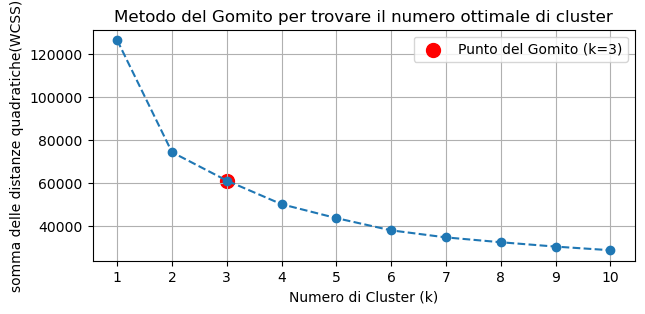

In [132]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# caricamento del dataset per il k-means standardizzato
dfPreStand = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')

# features usate per il clustering
featuresTocluster = ['matches', 'play_time', 'assists', 'kd_ratio', 'assists', 'headshots',
                        'score', 'missed_shots', 'hits_shots', 'suicides']
X = dfPreStand[featuresTocluster]

# vettore delle somme delle distanze quadratiche(inertia) per k che varierà nel range
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia è il valore del WCSS per k
    
    
# Traccia il grafico della regola del gomito
plt.figure(figsize=(7, 3))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('somma delle distanze quadratiche(WCSS)')
plt.title('Metodo del Gomito per trovare il numero ottimale di cluster')
plt.xticks(k_range)  # Visualizza ogni valore di k sull'asse x
plt.grid(True)

# punto del gomito su k=3
plt.scatter(3, wcss[2], s=100, c='red', label='Punto del Gomito (k=3)')
plt.legend()
plt.show()

Come si può notare dopo *k=3* l'inertia diminuisce in modo meno significativo, per cui il *valore naturale*, ovvero il miglior valore è *k=4*.

#### 4.5) Assegnazione degli esempi alle classi
A questo punto trovato k, si proce con l'esecuzione del k-means con *k=4*(cluster) e si assegnano le classi agli esempi del dataset.

In [133]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)


# aggiunta delle label risultanti(classi) ai dataset preprocessati
dfStandClustered = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')
dfClustered = pd.read_csv('datasets/df_preprocessed.csv')


# aggiunta label classe giocatore ai due dataset
dfStandClustered['cluster_label'] = kmeans.labels_
dfClustered['cluster_label'] = kmeans.labels_


# salvataggio del dataset con label sulla classe(clustering) del giocatore
file_path = 'datasets/player_class_datasets/df_stand_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfStandClustered.to_csv(file_path, index=False)

file_path = 'datasets/player_class_datasets/df_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfClustered.to_csv(file_path, index=False)

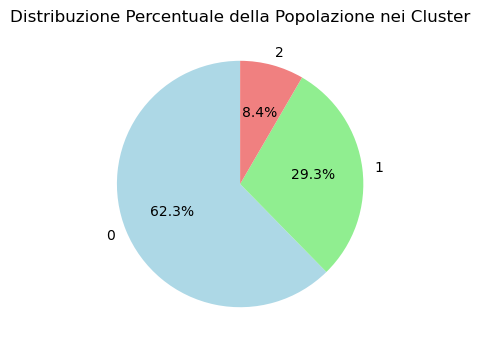

In [134]:

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
plt.figure(figsize=(4, 4))

# Conta il numero di punti in ciascun cluster
cluster_counts = dfClustered['cluster_label'].value_counts()

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('')
plt.title('Distribuzione Percentuale della Popolazione nei Cluster')
plt.show()

## ) Local Search for Optimization(CSP e Ricerca Locale)

L'idea è quella di rappresentare il problema dell'assegnazione delle risorse limitate tramite un algoritmo di ricerca rispetto alle assegnazioni sul CSP. Il problema codificherà dei criteri codificandoli tramite **Funzione Obiettivo**/**Soft Constraints** che guideranno la ricerca di una soluzione. 

A causa della complessità dello spazio di ricerca legato in modo esponenziale rispetto alla quantità di giocatori disponibili, la ricerca non sarà esaustiva, verrà quindi usato un **Algoritmo di Ricerca Locale**. 

A causa delle risorse limitate(partite istanziabili), alcuni giocatori potrebbero non riuscire ad essere assegnati ad alcuna partita, quindi potrebbe non esistere un'assegnazione(soluzione) che soddisfi tutti i vincoli ma che li soddisfi solo parzialmente. Vogliamo quindi soddisfare quanti più vincoli possibili, trasfare in soft constraints alcuni hard constraints e massimizzare l'ottimalità della soluzione. Per cui l'algoritmo di ricerca locale scelto sarà un algoritmo *Local Search for Optimization*.



I criteri che contribuiranno all'ottimizzazione saranno:

- **Massimizzare l'utilizzo delle risorse**: Massimizzare il numero totale di giocatori giocanti, cercando di servire quanti più utenti online possibili
- **Massimizzare la popolazione della partita**: Massimizzare la popolazione delle partite significherà incentivare il riempimento delle partite, evitando di istanziare partite sottoutilizzate e quindi di utilizzare ulteriori risorse(limitate). 
---
Quindi si vuole veicolare la ricerca verso soluzioni che tendono a riempire tutte le partite istanziate, evitando di generare soluzioni in cui ci sono partite che tendono a non riempirsi. Questo è implementabile aggiungendo una penalità che cresce quando la differenza tra il numero di giocatori in una partita e la capacità massima della partita aumenta.

---
- **Tempo di attesa dei giocatori in coda**: Minimizzare il numero di giocatori non assegnati ad una partita che sono in attesa da più tempo. Questi verranno preferiti nelle assegnazioni alle partite
- **rate quitting**:  Minimizzare il numero di giocatori con un alto tasso di abbandono, sfavorendoli all'assegnazione di una partita. Questo permetterà di favorire giocatori che mantengono le partite piene, inducendo quindi il pieno utilizzo delle risorse server(giocatori che abbandonano facilmente una partita, potrebbero richiedere di partecipare a nuove istanze, portando a non sfruttare pienamente le risorse). 
- **Partite con giocatori con della stessa classe**: Ad una partita verranno assegnati giocatori che fanno parte della stessa classe naturale(stile di gioco - abilità), riducendo la possibilità che questi giocatori differiscano troppo tra loro



## .2) Google OR-Tools 
Per il tipo di problema di *Local Search for Optimization* ho deciso di utilizzare la libreria [Google OR-Tools](https://developers.google.com/optimization?hl=it). Questa libreria mi permette di gestire aspetti riguardanti:
- **Supporto per CSP**: OR-Tools è pensata per risolvere *Constraint Satisfaction Problems (CSP)*
- **Gestione di Constraint**: consentendo sia vincoli hard che soft (vincoli hard saranno usati per gestire la capacità massima delle partite)
- **Funzione Obiettivo**: che guiderà le soluzioni ottimali
- **Tecninche di ricerca locale**: offrendo algoritmi di ricerca locale combinabili con *simulated annealing* e *tabu search*, affrontati durante il corso

*La penalità dei soft constraint verranno incorporate nella funzione obiettivo per l'ottimizzazione*

In [4]:
#Installazione Google OR-Tools
!pip install ortools

In [5]:
# importazione della libreria Google OR-Tools
from ortools.sat.python import cp_model

# creazione del modello
model = cp_model.CpModel()


# configurazione parametri
availablePlayers = 200 # giocatori dispobili
instancesAvailableMatches = 15 # istanze partite disponibili ad essere avviate
playerCapacityMatches = 10 # capacità partite
playersClassCount = 3; # numero di classi di abilità per i giocatori


# inizializzazione variabili CSP giocatori
playerAssignment = []
for i in range(availablePlayers):
    cspPVar = model.NewIntVar(
        
        # range dominio variabile (un valore nel range indicherà a quale partita è assegnato il giocatore)
        # -1 indica che il giocatre non è stato assegnato a nessuna partita
        -1, instancesAvailableMatches,
        f'player_assignment_{i}' # etichetta variabile CSP
    )
    playerAssignment.append(cspPVar)
    
    
    
    
# inizializzazione variabili CSP istanze partite
matchAssignment = []
for i in range(instancesAvailableMatches):
    cspMVar = model.NewIntVar(
        
        # range dominio variabile (valore nel range indicherà che classe di giocatori ospiterà la partita)
        0, playersClassCount, 
        f'match_assignment_{i}' # etichetta variabile CSP
    )
    matchAssignment.append(cspMVar)

    
    
    
# inizializzazione hard constraints


print(playerAssignment)
print(matchAssignment)

[player_assignment_0(-1..15), player_assignment_1(-1..15), player_assignment_2(-1..15), player_assignment_3(-1..15), player_assignment_4(-1..15), player_assignment_5(-1..15), player_assignment_6(-1..15), player_assignment_7(-1..15), player_assignment_8(-1..15), player_assignment_9(-1..15), player_assignment_10(-1..15), player_assignment_11(-1..15), player_assignment_12(-1..15), player_assignment_13(-1..15), player_assignment_14(-1..15), player_assignment_15(-1..15), player_assignment_16(-1..15), player_assignment_17(-1..15), player_assignment_18(-1..15), player_assignment_19(-1..15), player_assignment_20(-1..15), player_assignment_21(-1..15), player_assignment_22(-1..15), player_assignment_23(-1..15), player_assignment_24(-1..15), player_assignment_25(-1..15), player_assignment_26(-1..15), player_assignment_27(-1..15), player_assignment_28(-1..15), player_assignment_29(-1..15), player_assignment_30(-1..15), player_assignment_31(-1..15), player_assignment_32(-1..15), player_assignment_3